## Dust Mass Functions

---

### Imports

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from astropy import units as u
from scipy.stats import binned_statistic
from tabulate import tabulate
from astropy.cosmology import FlatLambdaCDM
from lmfit import Model
utils.rcparams()

---

### Create SGP Samples

In [2]:
# Load the reliable sample
sgp = utils.full_loader('HATLAS_SGP_DR3_15')
sgp_reliable_gals = sgp[(sgp['SG'] == 1) & (sgp['reliability'] >= 0.8) & (sgp['z1_median'] > 0)]
sgp_reliable_gals = sgp_reliable_gals.reset_index()

print('The number of objects being used in our sample = {}'.format(len(sgp_reliable_gals)))

The number of objects being used in our sample = 81895


In [3]:
# Set up parameters for SED fitting and sample creation
sgp_params = {'ID': 'IDNAME',
               'redshift': 'z1_median',
               'redshift_error': 'z1_err',
               'wavelengths_obs_um': np.array([100,160,250,350,500]),
               'sed_wavelengths_obs_um': np.array([100,160,250,350,500]),
               'flux_jy': ['F100BEST', 'F160BEST', 'F250BEST','F350BEST','F500BEST'],
               'flux_error_jy': ['E100BEST', 'E160BEST', 'E250BEST','E350BEST','E500BEST'],
               'calibration_percent': np.array([7,7,5.5,5.5,5.5])}

In [4]:
# Run sample creation and SED fitting 
SGP_sample = utils.create_sample(sgp_reliable_gals, sgp_params, fixed_beta=2)
SGP_sample_15_t_25 = utils.create_sample(sgp_reliable_gals, sgp_params, t_range=(15,25), fixed_beta=2)
utils.save_result(SGP_sample, 'SGP_sample')
utils.save_result(SGP_sample_15_t_25, 'SGP_sample_15_t_25')

Creating Sample:   0%|          | 39/81895 [00:00<03:32, 385.40it/s]

Creating Sample: 100%|██████████| 81895/81895 [03:09<00:00, 432.38it/s]


In [5]:
# Define surveys from parameter file
sgp_corrections = utils.load_result('sgp_correction_factors')
area = 303*(u.deg**2)
kappa_250 = 0.89
cosmology = [70*u.km/u.s/u.Mpc, 0.3, 0, 0.7]

parameters = {'area': area,
              'cosmology': cosmology,
              'submm correction': sgp_corrections['Flux_correction'],
              'id correction': sgp_corrections['ID_correction']}

SGP_survey = utils.Survey(SGP_sample, parameters)
SGP_survey_15_t_25 = utils.Survey(SGP_sample_15_t_25, parameters)

---

### Dust Properties

#### Photometry

In [6]:
# We consider the fraction of sources that have PACS photometry
snr_100 = sgp_reliable_gals['F100BEST']/sgp_reliable_gals['E100BEST']
snr_160 = sgp_reliable_gals['F160BEST']/sgp_reliable_gals['E160BEST']
snr_250 = sgp_reliable_gals['F250BEST']/sgp_reliable_gals['E250BEST']
snr_350 = sgp_reliable_gals['F350BEST']/sgp_reliable_gals['E350BEST']
snr_500 = sgp_reliable_gals['F500BEST']/sgp_reliable_gals['E500BEST']
redshifts = sgp_reliable_gals['z1_median']

snrs = [snr_100, snr_160, snr_250, snr_350, snr_500]
snr_mins = [3, 3, 4, 4, 4]
z_bins = [0,0.2,0.4,0.6,0.8,1]

snr_redshift = []
for i in range(len(z_bins)-1):
    snr_wave = []
    for snr, snr_min in zip(snrs, snr_mins):
        n = len([signal for signal,z in zip(snr,redshifts) if (z > z_bins[i]) & (z < z_bins[i+1])])
        n_snr = len([signal for signal,z in zip(snr,redshifts) if (z > z_bins[i]) & (z < z_bins[i+1]) & (signal > snr_min)])
        snr_percent = (n_snr/n)*100
        snr_wave.append(snr_percent)
    snr_redshift.append(snr_wave)

snr_table = tabulate(snr_redshift, headers=[r'100um', r'160um', r'250um', r'350um', r'500um'], floatfmt='.1f',tablefmt='fancy_grid')
print(snr_table)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   100um │   160um │   250um │   350um │   500um │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│    22.6 │    28.0 │    99.3 │    31.4 │     5.0 │
├─────────┼─────────┼─────────┼─────────┼─────────┤
│     6.0 │     7.8 │    98.6 │    20.3 │     2.7 │
├─────────┼─────────┼─────────┼─────────┼─────────┤
│     3.0 │     4.4 │    96.9 │    28.1 │     4.6 │
├─────────┼─────────┼─────────┼─────────┼─────────┤
│     1.4 │     2.8 │    96.0 │    37.5 │     6.7 │
├─────────┼─────────┼─────────┼─────────┼─────────┤
│     0.9 │     2.1 │    95.3 │    45.0 │     8.0 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛


#### Dust Temperatures

In [7]:
# Get redshifts and dust temperatures of all SGP sample
sgp_redshifts = SGP_survey.get_redshifts()
sgp_redshift_errors = SGP_survey.get_redshift_errors()
sgp_dust_temperatures = SGP_survey.get_dust_temperatures()
sgp_dust_temperature_errors = [SGP_survey.galaxies[gal].sed_results['T_c_err'] for gal in range(len(SGP_survey.galaxies))]

# Get redshifts and dust temperatures of SGP sample (within bounds) and calculate the median
z_bins_t = [0,0.2,0.4,0.6,0.8,1]
t_median, z_bins_t, _ = binned_statistic(sgp_redshifts, sgp_dust_temperatures, bins=z_bins_t, statistic=np.nanmedian)
t_low, _, _ = binned_statistic(sgp_redshifts, sgp_dust_temperatures, bins=z_bins_t, statistic=lambda x: np.percentile(x,[16]))
t_high, _, _ = binned_statistic(sgp_redshifts, sgp_dust_temperatures, bins=z_bins_t, statistic=lambda x: np.percentile(x,[84]))
t_median_low = t_median-t_low
t_median_high = t_high-t_median
z_bin_centers_t = (z_bins_t[:-1] + z_bins_t[1:]) / 2

In [8]:
# Count the number of photometric constraints that have SNR > 4 for each galaxy
sgp_n_phot_greater_snr = [(SGP_survey.galaxies[it].sed_flux_jy/SGP_survey.galaxies[it].sed_fluxerr_jy > 4).sum() for it in range(len(SGP_survey.galaxies))]

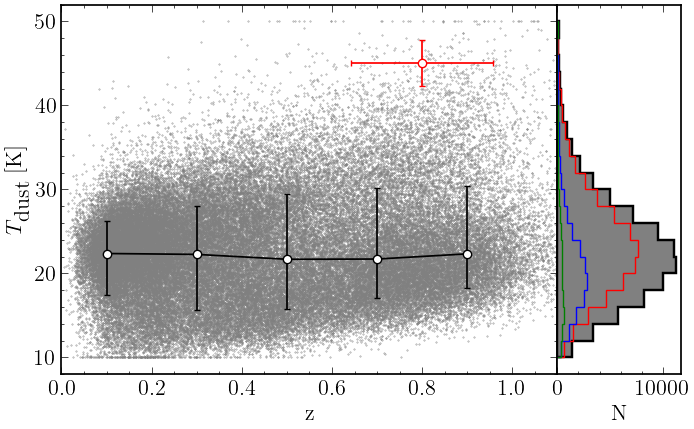

In [9]:
# Plot of the dust temperatures
n_bins = 20
n_phot_bins = [1,2,3]
colours_snr = ['r', 'b', 'g']

fig, ax = plt.subplots()
ax.scatter(sgp_redshifts, sgp_dust_temperatures, c='gray', s=0.1)
ax.errorbar(0.8, 45, xerr=np.nanmedian(sgp_redshift_errors), yerr=np.nanmedian(sgp_dust_temperature_errors), fmt='o', c='r')
ax.errorbar(z_bin_centers_t, t_median, yerr=(t_median_low, t_median_high), fmt='o-')
ax.set_xlabel(r'z')
ax.set_ylabel(r'$T_{\textrm{dust}}$ [K]')
ax.set_xlim(0, 1.1)
axin = ax.inset_axes([1,0,0.25,1])
axin.hist(sgp_dust_temperatures, bins=n_bins, range=(10,50), histtype='stepfilled', linewidth=1.75, ec='k', fc='gray', orientation='horizontal')
for n_phot, colour in zip(n_phot_bins, colours_snr):
    axin.hist([t for t,n in zip(sgp_dust_temperatures, sgp_n_phot_greater_snr) if n == n_phot], bins=n_bins, range=(10,50), orientation='horizontal', histtype='step', ec=colour, linewidth=1)
axin.set_yticks([])
axin.set_xlabel(r'N')
ax.set_rasterized(True)
plt.savefig(os.getcwd()+ '/figures/Figure_3_1.pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [10]:
# Print dust temperature table

table_headers = [r'T (median)', r'T (low)', r'T (high)']
table_array = np.array([t_median, t_median-t_low, t_high-t_median]).T

table = tabulate(table_array, headers=table_headers, floatfmt='.2f',tablefmt='fancy_grid')
print(table)

╒══════════════╤═══════════╤════════════╕
│   T (median) │   T (low) │   T (high) │
╞══════════════╪═══════════╪════════════╡
│        22.37 │      4.99 │       3.89 │
├──────────────┼───────────┼────────────┤
│        22.27 │      6.65 │       5.73 │
├──────────────┼───────────┼────────────┤
│        21.68 │      5.93 │       7.74 │
├──────────────┼───────────┼────────────┤
│        21.71 │      4.67 │       8.46 │
├──────────────┼───────────┼────────────┤
│        22.33 │      4.05 │       8.02 │
╘══════════════╧═══════════╧════════════╛


---

### Dust Mass Functions

In [11]:
# Plotting choices
z_bins = np.array([0,0.2,0.4,0.6,0.8,1])
logm_bins = np.array([5,5.25,5.5,5.75,6,6.25,6.5,6.75,7,7.25,7.5,7.75,8,8.25,8.5,8.75,9,9.25,9.5,9.75,10,10.25,10.5,10.75,11])
logl_bins = np.array([21,21.25,21.5,21.75,22,22.25,22.5,22.75,23,23.25,23.5,23.75,24,24.25,24.5,24.75,25,25.25,25.5,25.75,26,26.25,26.5,26.75,27])
colours = ['k', 'r', 'b', 'g', 'y']

In [12]:
# Distribution of dust temperatures between 15K and 25K
t_free_prior = SGP_survey_15_t_25.get_dust_temperatures()
t_unconstrained = [t for t in t_free_prior if (t > 15.1) & (t < 24.9)]
print('The number of galaxies with unconstrained dust temperatures between 15K < T < 25K = {} ({:.2f}%)'.format(len(t_unconstrained), (len(t_unconstrained)/len(t_free_prior))*100))
t_free_updated = [t if (t > 15.1) & (t < 24.9) else 20. for t in t_free_prior]

The number of galaxies with unconstrained dust temperatures between 15K < T < 25K = 48072 (58.70%)


#### 1/V Method (T = 20K)

In [13]:
SGP_vmax_t20 = SGP_survey.binned_function('dust mass', 'Vmax', 250, z_bins, logm_bins, fixed_t=20, fixed_beta=2, fixed_limit=0.0294, kappa=kappa_250, n_mc=100)

Calculating Sub-mm Correction Factors
Calculating ID Correction Factors
Calculating Dust Masses


Vmax (Redshift Slice):   0%|          | 0/5 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Monte Carlo Simulation: 100%|██████████| 100/100 [05:36<00:00,  3.36s/it]


#### PC00 Method (T = 20K)

In [14]:
SGP_pc00_t20 = SGP_survey.binned_function('dust mass', 'PC00', 250, z_bins, logm_bins, fixed_t=20, fixed_beta=2, fixed_limit=0.0294, kappa=kappa_250, n_mc=100)

Calculating Sub-mm Correction Factors
Calculating ID Correction Factors
Calculating Dust Masses


Monte Carlo Simulation: 100%|██████████| 100/100 [05:37<00:00,  3.37s/it]


#### PC00+D11 Method (15K < T < 25K)

In [15]:
SGP_pc00_d11 = SGP_survey_15_t_25.binned_function('dust mass', 'PC00+D11', 250, z_bins, logm_bins, t_inputs=t_free_updated, fixed_beta=2, fixed_snr=4, kappa=kappa_250, n_mc=100)

Calculating Sub-mm Correction Factors
Calculating ID Correction Factors
Calculating Dust Masses


Monte Carlo Simulation: 100%|██████████| 100/100 [05:42<00:00,  3.42s/it]


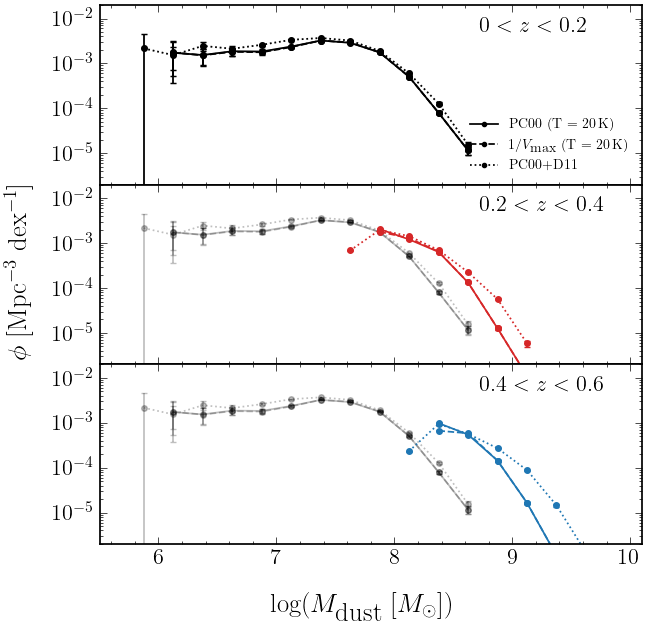

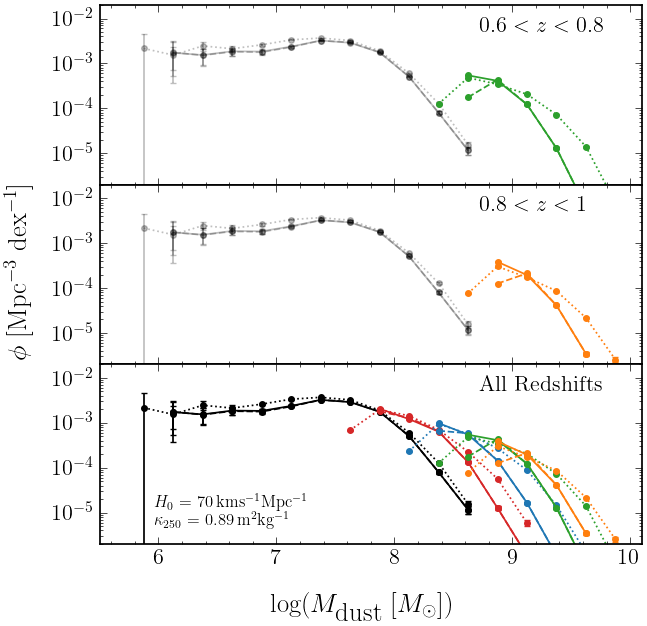

In [16]:
# Labelling
z_intervals = [r'$0 < z < 0.2$', r'$0.2 < z < 0.4$', r'$0.4 < z < 0.6$', r'$0.6 < z < 0.8$', r'$0.8 < z < 1$']
methods = [r'PC00 (T = 20\,K)', r'$1/V_{\textrm{max}}$ (T = 20\,K)', r'PC00+D11']
method_linestyles = ['o-', 'o--', 'o:']
method_mfc = ['k', 'k', 'k']
colours = ['k', 'tab:red', 'tab:blue', 'tab:green', 'tab:orange']

counter = 0

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(7,7))
axes = [ax1, ax2, ax3]

# Loop through methods for labels
for method,line,mfc in zip(methods, method_linestyles, method_mfc):
    ax1.plot([], [], line, mfc=mfc, c='k', label=method)

for ax in axes:
    
    # Error bars from SGP models
    ax.errorbar(SGP_pc00_t20['logx_bin_centers'], SGP_pc00_t20['phi_grid'][0], SGP_pc00_t20['phi_sigma'][0], fmt='o-', mfc='k', markersize=4, c='k', alpha=0.25)
    ax.errorbar(SGP_vmax_t20['logx_bin_centers'], SGP_vmax_t20['phi_grid'][0], SGP_vmax_t20['phi_sigma'][0], fmt='o--', mfc='k', markersize=4, c='k', alpha=0.25)
    ax.errorbar(SGP_pc00_d11['logx_bin_centers'], SGP_pc00_d11['phi_grid'][0], SGP_pc00_d11['phi_sigma'][0], fmt='o:', mfc='k', markersize=4, c='k', alpha=0.25)
    ax.errorbar(SGP_pc00_t20['logx_bin_centers'], SGP_pc00_t20['phi_grid'][counter], SGP_pc00_t20['phi_sigma'][counter], fmt='o-', mfc=colours[counter], markersize=4, c=colours[counter])
    ax.errorbar(SGP_vmax_t20['logx_bin_centers'], SGP_vmax_t20['phi_grid'][counter], SGP_vmax_t20['phi_sigma'][counter], fmt='o--', mfc=colours[counter], markersize=4, c=colours[counter])
    ax.errorbar(SGP_pc00_d11['logx_bin_centers'], SGP_pc00_d11['phi_grid'][counter], SGP_pc00_d11['phi_sigma'][counter], fmt='o:', mfc=colours[counter], markersize=4, c=colours[counter])

    ax.text(0.7, 0.85, z_intervals[counter], fontsize=16, transform=ax.transAxes)
    counter += 1

    ax.semilogy()
    ax.set_xlim(5.5, 10.1)
    ax.set_ylim(2e-6, 2e-2)
ax1.legend(loc='lower right', fontsize=10, markerscale=0.5)
plt.subplots_adjust(hspace=0)
fig.supxlabel(r'log($M_{\textrm{dust}}$ [$M_{\odot}$])', y=0)
fig.supylabel(r'$\phi$ [Mpc$^{-3}$ dex$^{-1}$]', x=-0.01)
plt.savefig(os.getcwd() + '/figures/Figure_3_4_part1.pdf', dpi=1000, bbox_inches='tight')
plt.show()

fig, (ax4, ax5, ax6) = plt.subplots(3,1, sharex=True, figsize=(7,7))
axes = [ax4, ax5, ax6]
for ax in axes:

    # If final panel add text
    if counter == 5:
        ax6.text(0.7, 0.85, 'All Redshifts', fontsize=16, transform=ax.transAxes)
        ax6.text(0.1, 0.2, r'$H_0$ = 70\,kms$^{-1}$Mpc$^{-1}$', fontsize=12, transform=ax6.transAxes)
        ax6.text(0.1, 0.1, r'$\kappa_{250}$ = 0.89\,m$^{2}$kg$^{-1}$', fontsize=12, transform=ax6.transAxes)

        # Multicoloured lines for final panel
        for it in range(counter):
            ax6.errorbar(SGP_pc00_t20['logx_bin_centers'], SGP_pc00_t20['phi_grid'][it], SGP_pc00_t20['phi_sigma'][it], fmt='o-', mfc=colours[it], markersize=4, c=colours[it])
            ax6.errorbar(SGP_vmax_t20['logx_bin_centers'], SGP_vmax_t20['phi_grid'][it], SGP_vmax_t20['phi_sigma'][it], fmt='o--', mfc=colours[it], markersize=4, c=colours[it])
            ax6.errorbar(SGP_pc00_d11['logx_bin_centers'], SGP_pc00_d11['phi_grid'][it], SGP_pc00_d11['phi_sigma'][it], fmt='o:', mfc=colours[it], markersize=4, c=colours[it])

    else:
        # Error bars from SGP models
        ax.errorbar(SGP_pc00_t20['logx_bin_centers'], SGP_pc00_t20['phi_grid'][0], SGP_pc00_t20['phi_sigma'][0], fmt='o-', mfc='k', markersize=4, c='k', alpha=0.25)
        ax.errorbar(SGP_vmax_t20['logx_bin_centers'], SGP_vmax_t20['phi_grid'][0], SGP_vmax_t20['phi_sigma'][0], fmt='o--', mfc='k', markersize=4, c='k', alpha=0.25)
        ax.errorbar(SGP_pc00_d11['logx_bin_centers'], SGP_pc00_d11['phi_grid'][0], SGP_pc00_d11['phi_sigma'][0], fmt='o:', mfc='k', markersize=4, c='k', alpha=0.25)
        ax.errorbar(SGP_pc00_t20['logx_bin_centers'], SGP_pc00_t20['phi_grid'][counter], SGP_pc00_t20['phi_sigma'][counter], fmt='o-', mfc=colours[counter], markersize=4, c=colours[counter])
        ax.errorbar(SGP_vmax_t20['logx_bin_centers'], SGP_vmax_t20['phi_grid'][counter], SGP_vmax_t20['phi_sigma'][counter], fmt='o--', mfc=colours[counter], markersize=4, c=colours[counter])
        ax.errorbar(SGP_pc00_d11['logx_bin_centers'], SGP_pc00_d11['phi_grid'][counter], SGP_pc00_d11['phi_sigma'][counter], fmt='o:', mfc=colours[counter], markersize=4, c=colours[counter])

        ax.text(0.7, 0.85, z_intervals[counter], fontsize=16, transform=ax.transAxes)
        counter += 1

    ax.semilogy()
    ax.set_xlim(5.5, 10.1)
    ax.set_ylim(2e-6, 2e-2)
plt.subplots_adjust(hspace=0)
fig.supxlabel(r'log($M_{\textrm{dust}}$ [$M_{\odot}$])', y=0)
fig.supylabel(r'$\phi$ [Mpc$^{-3}$ dex$^{-1}$]', x=-0.01)
plt.savefig(os.getcwd() + '/figures/Figure_3_4_part2.pdf', dpi=1000, bbox_inches='tight')
plt.show()

#### Fitting Schechter Functions

In [17]:
# Fitting Schechter functions for each redshift interval
results_pc00_t20 = SGP_survey.binned_function_fitting('dust mass', SGP_pc00_t20, logx_min_list=[[7.5],[7.75],[8.25],[8.5],[8.75]], fixed_params_list=[['alpha'],['alpha'],['alpha'],['alpha'],['alpha']], fixed_values_list=[[-1.22],[-1.22],[-1.22],[-1.22],[-1.22]])
results_pc00_d11 = SGP_survey_15_t_25.binned_function_fitting('dust mass', SGP_pc00_d11, logx_min_list=[[7.5],[7.75],[8.25],[8.5],[8.75]], fixed_params_list=[['alpha'],['alpha'],['alpha'],['alpha'],['alpha']], fixed_values_list=[[-1.22],[-1.22],[-1.22],[-1.22],[-1.22]])

100%|██████████| 10000/10000 [00:05<00:00, 1717.95it/s]


#### Convert Literature

In [18]:
# Define the cosmology that will be used for the following plots
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
redshifts = np.linspace(0,10,100)
look_back = [cosmo.lookback_time(z).value for z in redshifts]
rho_crit = cosmo.critical_density0.to(u.M_sun/u.Mpc**3).value

def z_to_lookback(z):
    return np.interp(z, redshifts, look_back)

def lookback_to_z(t):
    return np.interp(t, look_back, redshifts)

def density_to_density_parameter(rho):
    return rho/rho_crit

def density_parameter_to_density(omega):
    return omega*rho_crit

In [19]:
# Convert literature
literature = utils.load_result('literature_dmf')
literature_h70_k089 = utils.convert_literature(literature, cosmology_new=[70*u.km/u.s/u.Mpc, 0.3, 0, 0.7], kappa_new=0.89)

# Estimate the dust mass densities and add to literature (and SGP results)
results_pc00_t20 = utils.dust_mass_density(results_pc00_t20)
results_pc00_d11 = utils.dust_mass_density(results_pc00_d11)
literature_h70_k089 = utils.dust_mass_density_literature(literature_h70_k089)

/Users/bradleyward/Desktop/PhD/PhD_Projects/Thesis-Chapter-3-Dust-Mass-Functions/utils/literature.py:112: RuntimeWarning: divide by zero encountered in log10
  logphi_star_low_old, logphi_star_old, logphi_star_high_old = np.log10((10**logphi_star_perdex_low_old)/np.log(10)), np.log10((10**logphi_star_perdex_old)/np.log(10)), np.log10((10**logphi_star_perdex_high_old)/np.log(10))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


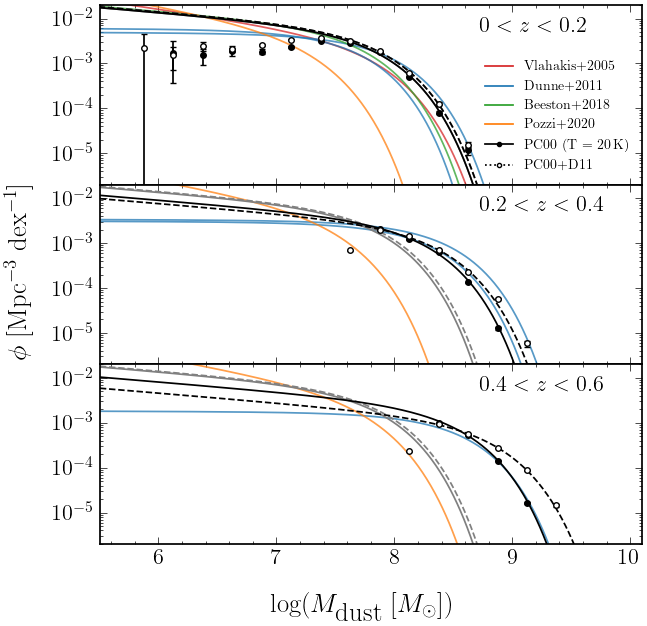

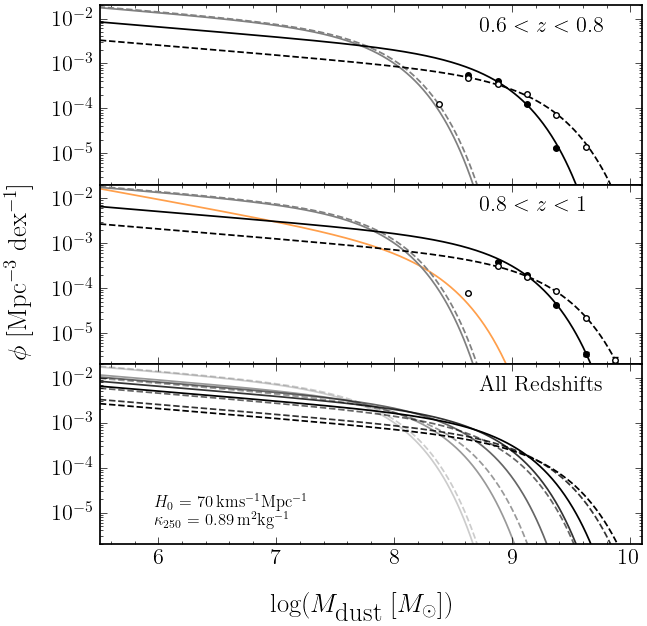

In [21]:
# Labelling
logm_range = np.linspace(4,11,1000)
z_intervals = [r'$0 < z < 0.2$', r'$0.2 < z < 0.4$', r'$0.4 < z < 0.6$', r'$0.6 < z < 0.8$', r'$0.8 < z < 1$']
methods = [r'Vlahakis+2005', r'Dunne+2011', r'Beeston+2018', r'Pozzi+2020', r'PC00 (T = 20\,K)', r'PC00+D11']
method_linestyles = ['-', '-', '-', '-', 'o-', 'o:']
method_mfc = ['none', 'none', 'none', 'none', 'k', 'white']
colours = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'k', 'k']
method_colours = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'k', 'k']

counter = 0

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(7,7))
axes = [ax1, ax2, ax3]

# Vlahakis et al., 2005
ax1.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Vlahakis+2005']['logm_star'][0], literature_h70_k089['Vlahakis+2005']['logphi_star_perdex'][0], literature_h70_k089['Vlahakis+2005']['alpha'][0]), linestyle='-', c='tab:red', alpha=0.75)

# Dunne et al., 2011
ax1.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Dunne+2011']['logm_star'][0], literature_h70_k089['Dunne+2011']['logphi_star_perdex'][0], literature_h70_k089['Dunne+2011']['alpha'][0]), linestyle='-', c='tab:blue', alpha=0.75)
ax1.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Dunne+2011']['logm_star'][1], literature_h70_k089['Dunne+2011']['logphi_star_perdex'][1], literature_h70_k089['Dunne+2011']['alpha'][1]), linestyle='-', c='tab:blue', alpha=0.75)
ax2.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Dunne+2011']['logm_star'][2], literature_h70_k089['Dunne+2011']['logphi_star_perdex'][2], literature_h70_k089['Dunne+2011']['alpha'][2]), linestyle='-', c='tab:blue', alpha=0.75)
ax2.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Dunne+2011']['logm_star'][3], literature_h70_k089['Dunne+2011']['logphi_star_perdex'][3], literature_h70_k089['Dunne+2011']['alpha'][3]), linestyle='-', c='tab:blue', alpha=0.75)
ax3.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Dunne+2011']['logm_star'][4], literature_h70_k089['Dunne+2011']['logphi_star_perdex'][4], literature_h70_k089['Dunne+2011']['alpha'][4]), linestyle='-', c='tab:blue', alpha=0.75)

# Beeston et al., 2018
ax1.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Beeston+2018']['logm_star'][0], literature_h70_k089['Beeston+2018']['logphi_star_perdex'][0], literature_h70_k089['Beeston+2018']['alpha'][0]), linestyle='-', c='tab:green', alpha=0.75)

# Pozzi et al., 2020
ax1.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Pozzi+2020']['logm_star'][0], literature_h70_k089['Pozzi+2020']['logphi_star_perdex'][0], literature_h70_k089['Pozzi+2020']['alpha'][0]), linestyle='-', c='tab:orange', alpha=0.75)
ax2.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Pozzi+2020']['logm_star'][1], literature_h70_k089['Pozzi+2020']['logphi_star_perdex'][1], literature_h70_k089['Pozzi+2020']['alpha'][1]), linestyle='-', c='tab:orange', alpha=0.75)
ax3.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Pozzi+2020']['logm_star'][2], literature_h70_k089['Pozzi+2020']['logphi_star_perdex'][2], literature_h70_k089['Pozzi+2020']['alpha'][2]), linestyle='-', c='tab:orange', alpha=0.75)

# Loop through methods for labels
for method,line,mfc,c in zip(methods, method_linestyles, method_mfc, method_colours):
    ax1.plot([], [], line, mfc=mfc, c=c, label=method)

for ax in axes:

    # Error bars and Schechter functions from SGP models
    ax.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_t20['logm_star'][0], results_pc00_t20['logphi_star_perdex'][0], results_pc00_t20['alpha'][0]), linestyle='-', c='grey')
    ax.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_d11['logm_star'][0], results_pc00_d11['logphi_star_perdex'][0], results_pc00_d11['alpha'][0]), linestyle='--', c='grey')
    ax.errorbar(SGP_pc00_t20['logx_bin_centers'], SGP_pc00_t20['phi_grid'][counter], SGP_pc00_t20['phi_sigma'][counter], fmt='o', mfc='k', markersize=4, c='k')
    ax.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_t20['logm_star'][counter], results_pc00_t20['logphi_star_perdex'][counter], results_pc00_t20['alpha'][counter]), linestyle='-', c='k')
    ax.errorbar(SGP_pc00_d11['logx_bin_centers'], SGP_pc00_d11['phi_grid'][counter], SGP_pc00_d11['phi_sigma'][counter], fmt='o', mfc='w', markersize=4, c='k')
    ax.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_d11['logm_star'][counter], results_pc00_d11['logphi_star_perdex'][counter], results_pc00_d11['alpha'][counter]), linestyle='--', c='k')

    ax.text(0.7, 0.85, z_intervals[counter], fontsize=16, transform=ax.transAxes)
    counter += 1

    ax.semilogy()
    ax.set_xlim(5.5, 10.1)
    ax.set_ylim(2e-6, 2e-2)
ax1.legend(loc='lower right', fontsize=10, markerscale=0.5)
plt.subplots_adjust(hspace=0)
fig.supxlabel(r'log($M_{\textrm{dust}}$ [$M_{\odot}$])', y=0)
fig.supylabel(r'$\phi$ [Mpc$^{-3}$ dex$^{-1}$]', x=-0.01)
plt.savefig(os.getcwd() + '/figures/Figure_3_5_part1.pdf', dpi=1000, bbox_inches='tight')
plt.show()

fig, (ax4, ax5, ax6) = plt.subplots(3,1, sharex=True, figsize=(7,7))
axes = [ax4, ax5, ax6]

ax5.plot(logm_range, utils.log_schechter_perdex(logm_range, literature_h70_k089['Pozzi+2020']['logm_star'][4], literature_h70_k089['Pozzi+2020']['logphi_star_perdex'][4], literature_h70_k089['Pozzi+2020']['alpha'][4]), linestyle='-', c='tab:orange', alpha=0.75)

for ax in axes:

    # If final panel add text
    if counter == 5:
        ax6.text(0.7, 0.85, 'All Redshifts', fontsize=16, transform=ax.transAxes)
        ax6.text(0.1, 0.2, r'$H_0$ = 70\,kms$^{-1}$Mpc$^{-1}$', fontsize=12, transform=ax6.transAxes)
        ax6.text(0.1, 0.1, r'$\kappa_{250}$ = 0.89\,m$^{2}$kg$^{-1}$', fontsize=12, transform=ax6.transAxes)

        # Grayscale lines for final panel
        for alpha,it in zip([0.2,0.4,0.6,0.8,1], range(counter)):
            ax6.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_t20['logm_star'][it], results_pc00_t20['logphi_star_perdex'][it], results_pc00_t20['alpha'][it]), linestyle='-', c='k', alpha=alpha)
            ax6.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_d11['logm_star'][it], results_pc00_d11['logphi_star_perdex'][it], results_pc00_d11['alpha'][it]), linestyle='--', c='k', alpha=alpha)

    else:
        # Error bars and Schechter functions from SGP models
        ax.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_t20['logm_star'][0], results_pc00_t20['logphi_star_perdex'][0], results_pc00_t20['alpha'][0]), linestyle='-', c='grey')
        ax.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_d11['logm_star'][0], results_pc00_d11['logphi_star_perdex'][0], results_pc00_d11['alpha'][0]), linestyle='--', c='grey')
        ax.errorbar(SGP_pc00_t20['logx_bin_centers'], SGP_pc00_t20['phi_grid'][counter], SGP_pc00_t20['phi_sigma'][counter], fmt='o', mfc='k', markersize=4, c='k')
        ax.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_t20['logm_star'][counter], results_pc00_t20['logphi_star_perdex'][counter], results_pc00_t20['alpha'][counter]), linestyle='-', c='k')
        ax.errorbar(SGP_pc00_d11['logx_bin_centers'], SGP_pc00_d11['phi_grid'][counter], SGP_pc00_d11['phi_sigma'][counter], fmt='o', mfc='w', markersize=4, c='k')
        ax.plot(logm_range, utils.log_schechter_perdex(logm_range, results_pc00_d11['logm_star'][counter], results_pc00_d11['logphi_star_perdex'][counter], results_pc00_d11['alpha'][counter]), linestyle='--', c='k')

        ax.text(0.7, 0.85, z_intervals[counter], fontsize=16, transform=ax.transAxes)
        counter += 1

    ax.semilogy()
    ax.set_xlim(5.5, 10.1)
    ax.set_ylim(2e-6, 2e-2)
plt.subplots_adjust(hspace=0)
fig.supxlabel(r'log($M_{\textrm{dust}}$ [$M_{\odot}$])', y=0)
fig.supylabel(r'$\phi$ [Mpc$^{-3}$ dex$^{-1}$]', x=-0.01)
plt.savefig(os.getcwd() + '/figures/Figure_3_5_part2.pdf', dpi=1000, bbox_inches='tight')
plt.show()

#### Evolution of Schechter Parameters

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_7669/138398270.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


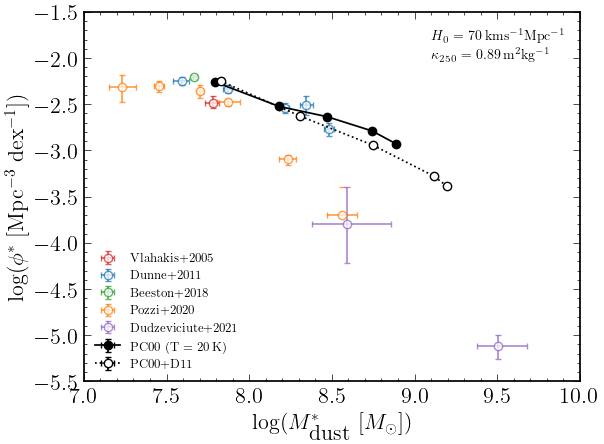

In [22]:
# Labelling
methods = [r'Vlahakis+2005', r'Dunne+2011', r'Beeston+2018', r'Pozzi+2020', r'PC00 (T = 20\,K)', r'PC00+D11']
method_linestyles = ['-', '-', '-', '-', 'o-', 'o--']
method_colours = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'k', 'k']
method_mfc = ['none', 'none', 'none', 'none', 'k', 'white']

fig, ax = plt.subplots()

# Vlahakis et al., 2005
ax.errorbar(literature_h70_k089['Vlahakis+2005']['logm_star'], literature_h70_k089['Vlahakis+2005']['logphi_star_perdex'], xerr=(literature_h70_k089['Vlahakis+2005']['logm_star']-literature_h70_k089['Vlahakis+2005']['logm_star_low'], literature_h70_k089['Vlahakis+2005']['logm_star_high']-literature_h70_k089['Vlahakis+2005']['logm_star']), yerr=(literature_h70_k089['Vlahakis+2005']['logphi_star_perdex']-literature_h70_k089['Vlahakis+2005']['logphi_star_perdex_low'], literature_h70_k089['Vlahakis+2005']['logphi_star_perdex_high']-literature_h70_k089['Vlahakis+2005']['logphi_star_perdex']), fmt='o', c='tab:red', alpha=0.75, label='Vlahakis+2005')

# Dunne et al., 2011
ax.errorbar(literature_h70_k089['Dunne+2011']['logm_star'], literature_h70_k089['Dunne+2011']['logphi_star_perdex'], xerr=(literature_h70_k089['Dunne+2011']['logm_star']-literature_h70_k089['Dunne+2011']['logm_star_low'], literature_h70_k089['Dunne+2011']['logm_star_high']-literature_h70_k089['Dunne+2011']['logm_star']), yerr=(literature_h70_k089['Dunne+2011']['logphi_star_perdex']-literature_h70_k089['Dunne+2011']['logphi_star_perdex_low'], literature_h70_k089['Dunne+2011']['logphi_star_perdex_high']-literature_h70_k089['Dunne+2011']['logphi_star_perdex']), fmt='o', c='tab:blue', alpha=0.75, label='Dunne+2011')

# Beeston et al., 2018
ax.errorbar(literature_h70_k089['Beeston+2018']['logm_star'], literature_h70_k089['Beeston+2018']['logphi_star_perdex'], xerr=(literature_h70_k089['Beeston+2018']['logm_star']-literature_h70_k089['Beeston+2018']['logm_star_low'], literature_h70_k089['Beeston+2018']['logm_star_high']-literature_h70_k089['Beeston+2018']['logm_star']), yerr=(literature_h70_k089['Beeston+2018']['logphi_star_perdex']-literature_h70_k089['Beeston+2018']['logphi_star_perdex_low'], literature_h70_k089['Beeston+2018']['logphi_star_perdex_high']-literature_h70_k089['Beeston+2018']['logphi_star_perdex']), fmt='o', c='tab:green', alpha=0.75, label='Beeston+2018')

# Pozzi et al., 2020
ax.errorbar(literature_h70_k089['Pozzi+2020']['logm_star'], literature_h70_k089['Pozzi+2020']['logphi_star_perdex'], xerr=(literature_h70_k089['Pozzi+2020']['logm_star']-literature_h70_k089['Pozzi+2020']['logm_star_low'], literature_h70_k089['Pozzi+2020']['logm_star_high']-literature_h70_k089['Pozzi+2020']['logm_star']), yerr=(literature_h70_k089['Pozzi+2020']['logphi_star_perdex']-literature_h70_k089['Pozzi+2020']['logphi_star_perdex_low'], literature_h70_k089['Pozzi+2020']['logphi_star_perdex_high']-literature_h70_k089['Pozzi+2020']['logphi_star_perdex']), fmt='o', c='tab:orange', alpha=0.75, label='Pozzi+2020')

# Dudzeviciute et al., 2021
ax.errorbar(literature_h70_k089['Dudzeviciute+2021']['logm_star'], literature_h70_k089['Dudzeviciute+2021']['logphi_star_perdex'], xerr=(literature_h70_k089['Dudzeviciute+2021']['logm_star']-literature_h70_k089['Dudzeviciute+2021']['logm_star_low'], literature_h70_k089['Dudzeviciute+2021']['logm_star_high']-literature_h70_k089['Dudzeviciute+2021']['logm_star']), yerr=(literature_h70_k089['Dudzeviciute+2021']['logphi_star_perdex']-literature_h70_k089['Dudzeviciute+2021']['logphi_star_perdex_low'], literature_h70_k089['Dudzeviciute+2021']['logphi_star_perdex_high']-literature_h70_k089['Dudzeviciute+2021']['logphi_star_perdex']), fmt='o', c='tab:purple', alpha=0.75, label='Dudzeviciute+2021')

# SGP Schechter parameters
ax.errorbar(results_pc00_t20['logm_star'], results_pc00_t20['logphi_star_perdex'], xerr=(results_pc00_t20['logm_star']-results_pc00_t20['logm_star_low'], results_pc00_t20['logm_star_high']-results_pc00_t20['logm_star']), yerr=(results_pc00_t20['logphi_star_perdex']-results_pc00_t20['logphi_star_perdex_low'], results_pc00_t20['logphi_star_perdex_high']-results_pc00_t20['logphi_star_perdex']), fmt='o-', mfc='k', c='k', label=r'PC00 (T = 20\,K)')
ax.errorbar(results_pc00_d11['logm_star'], results_pc00_d11['logphi_star_perdex'], xerr=(results_pc00_d11['logm_star']-results_pc00_d11['logm_star_low'], results_pc00_d11['logm_star_high']-results_pc00_d11['logm_star']), yerr=(results_pc00_d11['logphi_star_perdex']-results_pc00_d11['logphi_star_perdex_low'], results_pc00_d11['logphi_star_perdex_high']-results_pc00_d11['logphi_star_perdex']), fmt='o:', mfc='white', c='k', label=r'PC00+D11')

# Cosmology text
ax.text(0.7, 0.925, r'$H_0$ = 70\,kms$^{-1}$Mpc$^{-1}$', fontsize=10, transform=ax.transAxes)
ax.text(0.7, 0.875, r'$\kappa_{250}$ = 0.89\,m$^{2}$kg$^{-1}$', fontsize=10, transform=ax.transAxes)

ax.set_xlabel(r'log($M_{\textrm{dust}}^{*}$ [$M_{\odot}$])')
ax.set_ylabel(r'log($\phi^{*}$ [Mpc$^{-3}$ dex$^{-1}$])')
ax.set_xlim(7,10)
ax.set_ylim(-5.5,-1.5)
leg = ax.legend(loc='lower left', fontsize=9)
for lh in leg.legendHandles:
    lh.set_alpha(0.75)
plt.savefig(os.getcwd() + '/figures/Figure_3_6.pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [23]:
def dust_mass_evolution(z, M0, alphaM):
    """
    Function for the evolution of dust mass

    :param z: Redshift
    :param M0: Dust mass at redshift 0 [log(X)]
    :param alphaM: Low mass slope
    :return: Dust mass at redshift z [log(X)]
    """
    return M0*((1+z)**alphaM)

# Create a model for our radial offset distribution
m_model = Model(dust_mass_evolution)
params = m_model.make_params(M0=7.5, alphaM=1)
params['M0'].vary = True
params['alphaM'].vary = True
result_t20 = m_model.fit(results_pc00_t20['logm_star'], params, z=SGP_pc00_t20['z_bin_centers'])
result_d11 = m_model.fit(results_pc00_d11['logm_star'], params, z=SGP_pc00_d11['z_bin_centers'])

# Determine the best fitting values of parameters
M0_t20 = result_t20.params['M0'].value
M0_err_t20 = result_t20.params['M0'].stderr
alphaM_t20 = result_t20.params['alphaM'].value
alphaM_err_t20 = result_t20.params['alphaM'].stderr

M0_d11 = result_d11.params['M0'].value
M0_err_d11 = result_d11.params['M0'].stderr
alphaM_d11 = result_d11.params['alphaM'].value
alphaM_err_d11 = result_d11.params['alphaM'].stderr

In [24]:
# Best fitting characteristic dust mass
print('Best fitting characteristic dust mass equation (T = 20K): ({:.2f}+-{:.2f})(1+z)^({:.2f}+-{:.2f})'.format(M0_t20, M0_err_t20, alphaM_t20, alphaM_err_t20))
print('Best fitting characteristic dust mass equation (15K < T < 25K): ({:.2f}+-{:.2f})(1+z)^({:.2f}+-{:.2f})'.format(M0_d11, M0_err_d11, alphaM_d11, alphaM_err_d11))

Best fitting characteristic dust mass equation (T = 20K): (7.65+-0.05)(1+z)^(0.24+-0.01)
Best fitting characteristic dust mass equation (15K < T < 25K): (7.66+-0.10)(1+z)^(0.30+-0.03)


In [25]:
# Determine ratio of dust masses at different redshifts
mass_ratio_1_to_0_t20 = (10**dust_mass_evolution(1,M0_t20,alphaM_t20))/(10**dust_mass_evolution(0,M0_t20,alphaM_t20))
mass_ratio_1_to_0_d11 = (10**dust_mass_evolution(1,M0_d11,alphaM_d11))/(10**dust_mass_evolution(0,M0_d11,alphaM_d11))

mass_ratio_05_to_0_t20 = (10**dust_mass_evolution(0.5,M0_t20,alphaM_t20))/(10**dust_mass_evolution(0,M0_t20,alphaM_t20))
mass_ratio_05_to_0_d11 = (10**dust_mass_evolution(0.5,M0_d11,alphaM_d11))/(10**dust_mass_evolution(0,M0_d11,alphaM_d11))

print('Ratio of dust masses at z = 1 and z = 0 (T = 20K) is {:.2f}'.format(mass_ratio_1_to_0_t20))
print('Ratio of dust masses at z = 1 and z = 0 (15K < T < 25K) is {:.2f}'.format(mass_ratio_1_to_0_d11))

print('Ratio of dust masses at z = 0.5 and z = 0 (T = 20K) is {:.2f}'.format(mass_ratio_05_to_0_t20))
print('Ratio of dust masses at z = 0.5 and z = 0 (15K < T < 25K) is {:.2f}'.format(mass_ratio_05_to_0_d11))

Ratio of dust masses at z = 1 and z = 0 (T = 20K) is 24.98
Ratio of dust masses at z = 1 and z = 0 (15K < T < 25K) is 63.29
Ratio of dust masses at z = 0.5 and z = 0 (T = 20K) is 6.15
Ratio of dust masses at z = 0.5 and z = 0 (15K < T < 25K) is 10.17


/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_7669/3151714057.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


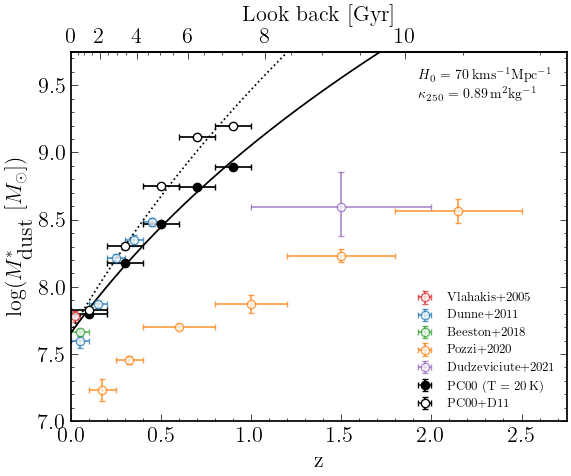

In [26]:
z_range = np.linspace(0,3,1000)

fig, ax = plt.subplots()

# Vlahakis et al., 2005
ax.errorbar(literature_h70_k089['Vlahakis+2005']['z_bin_centers'], literature_h70_k089['Vlahakis+2005']['logm_star'], xerr=np.diff(literature_h70_k089['Vlahakis+2005']['z_bins'])/2, yerr=(literature_h70_k089['Vlahakis+2005']['logm_star']-literature_h70_k089['Vlahakis+2005']['logm_star_low'], literature_h70_k089['Vlahakis+2005']['logm_star_high']-literature_h70_k089['Vlahakis+2005']['logm_star']), fmt='o', c='tab:red', alpha=0.75, label='Vlahakis+2005')

# Dunne et al., 2011
ax.errorbar(literature_h70_k089['Dunne+2011']['z_bin_centers'], literature_h70_k089['Dunne+2011']['logm_star'], xerr=np.diff(literature_h70_k089['Dunne+2011']['z_bins'])/2, yerr=(literature_h70_k089['Dunne+2011']['logm_star']-literature_h70_k089['Dunne+2011']['logm_star_low'], literature_h70_k089['Dunne+2011']['logm_star_high']-literature_h70_k089['Dunne+2011']['logm_star']), fmt='o', c='tab:blue', alpha=0.75, label='Dunne+2011')

# Beeston et al., 2018
ax.errorbar(literature_h70_k089['Beeston+2018']['z_bin_centers'], literature_h70_k089['Beeston+2018']['logm_star'], xerr=np.diff(literature_h70_k089['Beeston+2018']['z_bins'])/2, yerr=(literature_h70_k089['Beeston+2018']['logm_star']-literature_h70_k089['Beeston+2018']['logm_star_low'], literature_h70_k089['Beeston+2018']['logm_star_high']-literature_h70_k089['Beeston+2018']['logm_star']), fmt='o', c='tab:green', alpha=0.75, label='Beeston+2018')

# Pozzi et al., 2020
ax.errorbar(literature_h70_k089['Pozzi+2020']['z_bin_centers'], literature_h70_k089['Pozzi+2020']['logm_star'], xerr=np.diff(literature_h70_k089['Pozzi+2020']['z_bins'])/2, yerr=(literature_h70_k089['Pozzi+2020']['logm_star']-literature_h70_k089['Pozzi+2020']['logm_star_low'], literature_h70_k089['Pozzi+2020']['logm_star_high']-literature_h70_k089['Pozzi+2020']['logm_star']), fmt='o', c='tab:orange', alpha=0.75, label='Pozzi+2020')

# Dudzeviciute et al., 2021
ax.errorbar(literature_h70_k089['Dudzeviciute+2021']['z_bin_centers'], literature_h70_k089['Dudzeviciute+2021']['logm_star'], xerr=0.5, yerr=(literature_h70_k089['Dudzeviciute+2021']['logm_star']-literature_h70_k089['Dudzeviciute+2021']['logm_star_low'], literature_h70_k089['Dudzeviciute+2021']['logm_star_high']-literature_h70_k089['Dudzeviciute+2021']['logm_star']), fmt='o', c='tab:purple', alpha=0.75, label='Dudzeviciute+2021')

# Error bars for SGP models
ax.errorbar(SGP_pc00_t20['z_bin_centers'], results_pc00_t20['logm_star'], xerr=np.diff(z_bins)/2, yerr=(results_pc00_t20['logm_star']-results_pc00_t20['logm_star_low'], results_pc00_t20['logm_star_high']-results_pc00_t20['logm_star']), fmt='o', mfc='k', c='k', label=r'PC00 (T = 20\,K)')
ax.plot(z_range, dust_mass_evolution(z_range, M0_t20, alphaM_t20), 'k-')
ax.errorbar(SGP_pc00_d11['z_bin_centers'], results_pc00_d11['logm_star'], xerr=np.diff(z_bins)/2, yerr=(results_pc00_d11['logm_star']-results_pc00_d11['logm_star_low'], results_pc00_d11['logm_star_high']-results_pc00_d11['logm_star']), fmt='o', mfc='white', c='k', label=r'PC00+D11')
ax.plot(z_range, dust_mass_evolution(z_range, M0_d11, alphaM_d11), 'k:')

# Cosmology text
ax.text(0.7, 0.925, r'$H_0$ = 70\,kms$^{-1}$Mpc$^{-1}$', fontsize=10, transform=ax.transAxes)
ax.text(0.7, 0.875, r'$\kappa_{250}$ = 0.89\,m$^{2}$kg$^{-1}$', fontsize=10, transform=ax.transAxes)

ax.set_xlabel(r'z')
ax.set_ylabel(r'log($M_{\textrm{dust}}^{*}$ [$M_{\odot}$])')
ax.tick_params(axis='x', which='both', top=False)
secax = ax.secondary_xaxis('top', functions=(z_to_lookback, lookback_to_z))
secax.set_xticks(np.array([0,2,4,6,8,10,12]))
ax.set_xlim(0,2.75)
ax.set_ylim(7,9.75)
leg = ax.legend(loc='lower right', fontsize=9)
for lh in leg.legendHandles:
    lh.set_alpha(0.75)
secax.set_xlabel('Look back [Gyr]')
plt.savefig(os.getcwd() + '/figures/Figure_3_7.pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [27]:
# Schechter parameter headings
table_headers = [r'log(m)', r'log(M) [high]', r'log(M) [low]', r'log(phi)', r'log(phi) [high]', r'log(phi) [low]', r'alpha', r'DMD', r'DMD [high]', r'DMD [low]']

# BEst fitting T = 20K parameters
table_pc00_t20_parameters = np.array([results_pc00_t20['logm_star'], results_pc00_t20['logm_star_high']-results_pc00_t20['logm_star'], results_pc00_t20['logm_star']-results_pc00_t20['logm_star_low'], results_pc00_t20['logphi_star_perdex'], results_pc00_t20['logphi_star_perdex_high']-results_pc00_t20['logphi_star_perdex'], results_pc00_t20['logphi_star_perdex']-results_pc00_t20['logphi_star_perdex_low'], results_pc00_t20['alpha'], results_pc00_t20['dmd'], results_pc00_t20['dmd_high']-results_pc00_t20['dmd'], results_pc00_t20['dmd']-results_pc00_t20['dmd_low']]).T

# Best fitting 15K < T < 25K parameters
table_pc00_d11_parameters = np.array([results_pc00_d11['logm_star'], results_pc00_d11['logm_star_high']-results_pc00_d11['logm_star'], results_pc00_d11['logm_star']-results_pc00_d11['logm_star_low'], results_pc00_d11['logphi_star_perdex'], results_pc00_d11['logphi_star_perdex_high']-results_pc00_d11['logphi_star_perdex'], results_pc00_d11['logphi_star_perdex']-results_pc00_d11['logphi_star_perdex_low'], results_pc00_d11['alpha'], results_pc00_d11['dmd'], results_pc00_d11['dmd_high']-results_pc00_d11['dmd'], results_pc00_d11['dmd']-results_pc00_d11['dmd_low']]).T

# Create tables and print
table_pc00_t20 = tabulate(table_pc00_t20_parameters, headers=table_headers, floatfmt='.3f', tablefmt='fancy_grid')
table_pc00_d11 = tabulate(table_pc00_d11_parameters, headers=table_headers, floatfmt='.3f', tablefmt='fancy_grid')
print(table_pc00_t20)
print(table_pc00_d11)

╒══════════╤═════════════════╤════════════════╤════════════╤═══════════════════╤══════════════════╤═════════╤════════════╤══════════════╤═════════════╕
│   log(m) │   log(M) [high] │   log(M) [low] │   log(phi) │   log(phi) [high] │   log(phi) [low] │   alpha │        DMD │   DMD [high] │   DMD [low] │
╞══════════╪═════════════════╪════════════════╪════════════╪═══════════════════╪══════════════════╪═════════╪════════════╪══════════════╪═════════════╡
│    7.794 │           0.007 │          0.007 │     -2.260 │             0.011 │            0.011 │  -1.220 │ 176495.886 │     5190.086 │    5070.020 │
├──────────┼─────────────────┼────────────────┼────────────┼───────────────────┼──────────────────┼─────────┼────────────┼──────────────┼─────────────┤
│    8.181 │           0.005 │          0.005 │     -2.524 │             0.008 │            0.008 │  -1.220 │ 233925.662 │     5014.187 │    4909.552 │
├──────────┼─────────────────┼────────────────┼────────────┼───────────────────┼────────

In [28]:
# Print characteristic dust masses
logm_star_0_02_pc00_t20, logm_star_02_04_pc00_t20, logm_star_04_06_pc00_t20, logm_star_06_08_pc00_t20, logm_star_08_1_pc00_t20 = results_pc00_t20['logm_star']
logm_star_0_02_pc00_d11, logm_star_02_04_pc00_d11, logm_star_04_06_pc00_d11, logm_star_06_08_pc00_d11, logm_star_08_1_pc00_d11 = results_pc00_d11['logm_star']

print('Evolution in characteristic dust mass between 0 < z < 0.2 and 0.8 < z < 1 (T = 20K) = {:.2f}'.format((10**logm_star_08_1_pc00_t20)/(10**logm_star_0_02_pc00_t20)))
print('Evolution in characteristic dust mass between 0 < z < 0.2 and 0.8 < z < 1 (15K < T < 25K) = {:.2f} '.format((10**logm_star_08_1_pc00_d11)/(10**logm_star_0_02_pc00_d11)))

Evolution in characteristic dust mass between 0 < z < 0.2 and 0.8 < z < 1 (T = 20K) = 12.45
Evolution in characteristic dust mass between 0 < z < 0.2 and 0.8 < z < 1 (15K < T < 25K) = 23.35 


---

### Dust Mass Densities

In [29]:
# Driver et al., 2018 literature
literature_h70_k089['Driver+2018'] = {'z_bin_centers': np.array([0.05,0.1,0.17,0.24,0.32,0.41,0.51,0.62,0.75,0.91,1.1,1.32,1.6]), 'log_dd': np.array([-5.98,-5.9,-5.91,-5.91,-5.88,-5.97,-5.95,-5.83,-5.76,-5.5,-5.61,-5.6,-5.81]), 'log_dd_low': np.array([0.09,0.05,0.04,0.04,0.06,0.1,0.14,0.09,0.1,0.09,0.28,0.13,0.2]), 'log_dd_high': np.array([0.09,0.05,0.04,0.04,0.06,0.1,0.14,0.09,0.1,0.09,0.28,0.13,0.2])}

# Determine dust mass densities for Driver et al., 2018 study
literature_h70_k089['Driver+2018']['dmd'] = (10**literature_h70_k089['Driver+2018']['log_dd'])*rho_crit
literature_h70_k089['Driver+2018']['dmd_low'] = (10**(literature_h70_k089['Driver+2018']['log_dd'] - literature_h70_k089['Driver+2018']['log_dd_low']))*rho_crit
literature_h70_k089['Driver+2018']['dmd_high'] = (10**(literature_h70_k089['Driver+2018']['log_dd'] + literature_h70_k089['Driver+2018']['log_dd_high']))*rho_crit

print('The critical density in our cosmology = {}'.format(rho_crit))

The critical density in our cosmology = 135992947350.45705


/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_7669/2245969643.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


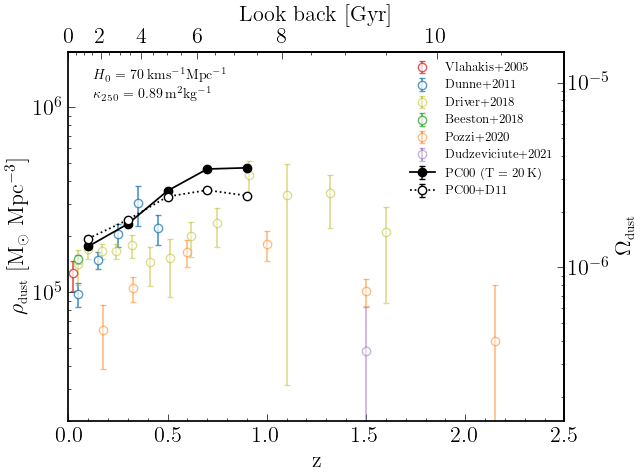

In [30]:
fig, ax = plt.subplots()

# Vlahakis et al., 2005
ax.errorbar(literature_h70_k089['Vlahakis+2005']['z_bin_centers'], literature_h70_k089['Vlahakis+2005']['dmd'], yerr=(literature_h70_k089['Vlahakis+2005']['dmd_high']-literature_h70_k089['Vlahakis+2005']['dmd'], literature_h70_k089['Vlahakis+2005']['dmd']-literature_h70_k089['Vlahakis+2005']['dmd_low']), fmt='o', c='tab:red', label='Vlahakis+2005', alpha=0.75)

# Dunne et al., 2011
ax.errorbar(literature_h70_k089['Dunne+2011']['z_bin_centers'], literature_h70_k089['Dunne+2011']['dmd'], yerr=(literature_h70_k089['Dunne+2011']['dmd_high']-literature_h70_k089['Dunne+2011']['dmd'], literature_h70_k089['Dunne+2011']['dmd']-literature_h70_k089['Dunne+2011']['dmd_low']), fmt='o', c='tab:blue', label='Dunne+2011', alpha=0.75)

# Driver et al., 2018
ax.errorbar(literature_h70_k089['Driver+2018']['z_bin_centers'], literature_h70_k089['Driver+2018']['dmd'], yerr=(literature_h70_k089['Driver+2018']['dmd_high']-literature_h70_k089['Driver+2018']['dmd'], literature_h70_k089['Driver+2018']['dmd']-literature_h70_k089['Driver+2018']['dmd_low']), fmt='o', c='tab:olive', label='Driver+2018', alpha=0.5)

# Beeston et al., 2018
ax.errorbar(literature_h70_k089['Beeston+2018']['z_bin_centers'], literature_h70_k089['Beeston+2018']['dmd'], yerr=(literature_h70_k089['Beeston+2018']['dmd_high']-literature_h70_k089['Beeston+2018']['dmd'], literature_h70_k089['Beeston+2018']['dmd']-literature_h70_k089['Beeston+2018']['dmd_low']), fmt='o', c='tab:green', label='Beeston+2018', alpha=0.75)

# Pozzi et al., 2020
ax.errorbar(literature_h70_k089['Pozzi+2020']['z_bin_centers'], literature_h70_k089['Pozzi+2020']['dmd'], yerr=(literature_h70_k089['Pozzi+2020']['dmd_high']-literature_h70_k089['Pozzi+2020']['dmd'], literature_h70_k089['Pozzi+2020']['dmd']-literature_h70_k089['Pozzi+2020']['dmd_low']), fmt='o', c='tab:orange', label='Pozzi+2020', alpha=0.5)

# Dudzeviciute et al., 2021
ax.errorbar(literature_h70_k089['Dudzeviciute+2021']['z_bin_centers'], literature_h70_k089['Dudzeviciute+2021']['dmd'], yerr=(literature_h70_k089['Dudzeviciute+2021']['dmd_high']-literature_h70_k089['Dudzeviciute+2021']['dmd'], literature_h70_k089['Dudzeviciute+2021']['dmd']-literature_h70_k089['Dudzeviciute+2021']['dmd_low']), fmt='o', c='tab:purple', label='Dudzeviciute+2021', alpha=0.5)

# Dust mass densities from SGP models
ax.errorbar(SGP_pc00_t20['z_bin_centers'], results_pc00_t20['dmd'], yerr=(results_pc00_t20['dmd_high']-results_pc00_t20['dmd'], results_pc00_t20['dmd']-results_pc00_t20['dmd_low']), fmt='o-', mfc='k', c='k', label=r'PC00 (T = 20\,K)')
ax.errorbar(SGP_pc00_d11['z_bin_centers'], results_pc00_d11['dmd'], yerr=(results_pc00_d11['dmd_high']-results_pc00_d11['dmd'], results_pc00_d11['dmd']-results_pc00_d11['dmd_low']), fmt='o:', mfc='white', c='k', label=r'PC00+D11')

# Cosmology text
ax.text(0.05, 0.925, r'$H_0$ = 70\,kms$^{-1}$Mpc$^{-1}$', fontsize=10, transform=ax.transAxes)
ax.text(0.05, 0.875, r'$\kappa_{250}$ = 0.89\,m$^{2}$kg$^{-1}$', fontsize=10, transform=ax.transAxes)

# Second axes for lookback time and dust density parameter
ax.semilogy()
ax.tick_params(axis='x', which='both', top=False)
ax.tick_params(axis='y', which='both', right=False)
secax_x = ax.secondary_xaxis('top', functions=(z_to_lookback, lookback_to_z))
secax_y = ax.secondary_yaxis('right', functions=(density_to_density_parameter, density_parameter_to_density))
secax.set_xticks(np.array([0,2,4,6,8,10,12]))

ax.set_xlim(0,2.5)
ax.set_ylim(2e4, 2e6)
ax.set_xlabel(r'z')
ax.set_ylabel(r'$\rho_{\textrm{\small dust}}$ [M$_\odot$ Mpc$^{-3}$]')
secax_x.set_xlabel(r'Look back [Gyr]')
secax_y.set_ylabel(r'$\Omega_{\textrm{\small dust}}$')
leg = ax.legend(fontsize=9, loc='upper right')
for lh in leg.legendHandles:
    lh.set_alpha(0.75)
plt.savefig(os.getcwd() + '/figures/Figure_3_8.pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [31]:
# Density evolution from first to last redshift bin
print('The density evolves by a factor of {:.2f} between 0 < z < 0.2 and 0.8 < z < 1'.format(results_pc00_t20['dmd'][-1]/results_pc00_t20['dmd'][0]))
print('The density evolves by a factor of {:.2f} between 0 < z < 0.2 and 0.8 < z < 1'.format(results_pc00_d11['dmd'][-1]/results_pc00_d11['dmd'][0]))

The density evolves by a factor of 2.66 between 0 < z < 0.2 and 0.8 < z < 1
The density evolves by a factor of 1.71 between 0 < z < 0.2 and 0.8 < z < 1


In [33]:
def double_powerlaw(z, alpha, beta, gamma, delta):
    """
    Generates a double power law model
    
    :param z: Redshift
    :param alpha: First parameter - first normalization
    :param beta: Second parameter - first power law
    :param gamma: Third parameter - second normalization
    :param delta: Fourth parameter - second power law
    :return: Double power law model
    """
    return alpha*(((1+z)**beta)/(1+(((1+z)/gamma)**delta)))

# Madau & Dickinson., 2014 double power law
z_range = np.linspace(0,5,1000)
madau_peak_z = z_range[np.argmax(double_powerlaw(z_range, 0.015, 2.7, 2.9, 5.6))]
print('The SFRD predicted by Madau & Dickinson, 2014 peaks at z ~ {:.2f}'.format(madau_peak_z))

The SFRD predicted by Madau & Dickinson, 2014 peaks at z ~ 1.86


In [34]:
# Sanders et al., 2003
sanders_2003 = {'z_bin_centers': np.array([0.03]),
                 'log_sfrd': np.array([-1.72]),
                 'log_sfrd_high': np.array([0.02]),
                 'log_sfrd_low': np.array([0.03])}

# Takeuchi et al., 2003
takeuchi_2003 = {'z_bin_centers': np.array([0.03]),
                 'log_sfrd': np.array([-1.95]),
                 'log_sfrd_high': np.array([0.2]),
                 'log_sfrd_low': np.array([0.2])}

# Wyder et al., 2005
wyder_2005 = {'z_bins': np.array([0.01,0.1]),
              'z_bin_centers': np.array([0.055]),
              'log_sfrd': np.array([-1.82]),
              'log_sfrd_high': np.array([0.09]),
              'log_sfrd_low': np.array([0.02])}

# Schiminovich et al., 2005
schiminovich_2005 = {'z_bins': np.array([0.2,0.4,0.6,0.8,1.2]),
                     'z_bin_centers': np.array([0.3,0.5,0.7,1]),
                     'log_sfrd': np.array([-1.50,-1.39,-1.20,-1.25]),
                     'log_sfrd_high': np.array([0.05,0.15,0.31,0.31]),
                     'log_sfrd_low': np.array([0.05,0.08,0.13,0.13])}

# Reddy et al., 2009
reddy_2009 = {'z_bins': np.array([1.9,2.7,3.4]),
               'z_bin_centers': np.array([2.3,3.05]),
               'log_sfrd': np.array([-0.75,-0.97]),
               'log_sfrd_high': np.array([0.09,0.11]),
               'log_sfrd_low': np.array([0.11,0.15])}

# Robotham et al., 2011
robotham_2011 = {'z_bin_centers': np.array([0.05]),
                 'log_sfrd': np.array([-1.77]),
                 'log_sfrd_high': np.array([0.08]),
                 'log_sfrd_low': np.array([0.09])}

# Magnelli et al., 2011
magnelli_2011 = {'z_bins': np.array([0.4,0.7,1,1.3,1.8,2.3]),
                 'z_bin_centers': np.array([0.55,0.85,1.15,1.55,2.05]),
                 'log_sfrd': np.array([-1.34,-0.96,-0.89,-0.91,-0.89]),
                 'log_sfrd_high': np.array([0.22,0.15,0.27,0.17,0.21]),
                 'log_sfrd_low': np.array([0.11,0.19,0.21,0.21,0.25])}

# Cucciati et al., 2012
cucciati_2012 = {'z_bins': np.array([0.05,0.2,0.4,0.6,0.8,1,1.2,1.7,2.5,3.5,4.5]),
                 'z_bin_centers': np.array([0.125,0.3,0.5,0.7,0.9,1.1,1.45,2.1,3,4]),
                 'log_sfrd': np.array([-1.75,-1.55,-1.44,-1.24,-0.99,-0.94,-0.95,-0.75,-1.04,-1.69]),
                 'log_sfrd_high': np.array([0.18,0.12,0.1,0.1,0.09,0.09,0.15,0.49,0.26,0.22]),
                 'log_sfrd_low': np.array([0.18,0.12,0.1,0.1,0.08,0.09,0.08,0.09,0.15,0.32])}

# Bouwens et al., 2013
bouwens_2013 = {'z_bin_centers': np.array([3.8,4.9,5.9,7,7.9]),
                 'log_sfrd': np.array([-1.29,-1.42,-1.65,-1.79,-2.09]),
                 'log_sfrd_high': np.array([0.05,0.06,0.08,0.1,0.11]),
                 'log_sfrd_low': np.array([0.05,0.06,0.08,0.1,0.11])}

# Schenker et al., 2013
schenker_2013 = {'z_bin_centers': np.array([7]),
                 'log_sfrd': np.array([-2.]),
                 'log_sfrd_high': np.array([0.1]),
                 'log_sfrd_low': np.array([0.11])}

# Magnelli et al., 2013
magnelli_2013 = {'z_bins': np.array([0.4,0.7,1,1.3,1.8,2.3]),
                 'z_bin_centers': np.array([0.55,0.85,1.15,1.55,2.05]),
                 'log_sfrd': np.array([-1.22,-1.10,-0.96,-0.94,-0.80]),
                 'log_sfrd_high': np.array([0.08,0.1,0.13,0.13,0.18]),
                 'log_sfrd_low': np.array([0.11,0.13,0.2,0.18,0.15])}

# Gruppioni et al., 2013
gruppioni_2013 = {'z_bins': np.array([0,0.3,0.45,0.6,0.8,1,1.2,1.7,2,2.5,3,4.2]),
                 'z_bin_centers': np.array([0.15,0.375,0.525,0.7,0.9,1.1,1.45,1.85,2.25,2.75,3.6]),
                 'log_sfrd': np.array([-1.64,-1.42,-1.32,-1.14,-0.94,-0.81,-0.84,-0.86,-0.91,-0.86,-1.36]),
                 'log_sfrd_high': np.array([0.09,0.03,0.05,0.06,0.05,0.04,0.04,0.02,0.09,0.15,0.23]),
                 'log_sfrd_low': np.array([0.11,0.04,0.05,0.06,0.06,0.05,0.04,0.03,0.12,0.23,0.5])}

# Combine studies for Madau & Dickinson., 2014 SFRD
madau_sfrd = {'sanders+2003': sanders_2003,
              'takeuchi+2003': takeuchi_2003,
              'wyder+2005': wyder_2005,
              'schiminovich+2005': schiminovich_2005,
              'reddy+2009': reddy_2009,
              'robotham+2011': robotham_2011,
              'magnelli+2011': magnelli_2011,
              'cucciati+2012': cucciati_2012,
              'bouwens+2013': bouwens_2013,
              'schenker+2013': schenker_2013,
              'magnelli+2013': magnelli_2013,
              'gruppioni+2013': gruppioni_2013}

In [35]:
def dmd_to_sfrd(dmd, t_depl=500, dgr=100):
    """
    Transforms dust mass density to star formation rate density
    
    :param dmd: Dust mass density [Msun Mpc-3]
    :param t_depl: Dust depletion timescale [Myr] (Default = 500 Myr)
    :param dgr: Dust to gas ratio (Default = 100)
    :return: Star formation rate density [Msun yr-1 Mpc-3]
    """
    dmd = dmd*(u.M_sun/(u.Mpc**3))
    t_depl = t_depl*u.Myr

    gmd = dmd*dgr
    sfrd = gmd/t_depl
    sfrd = sfrd.to(u.M_sun/u.yr/(u.Mpc**3))
    return sfrd.value

def sfrd_to_dmd(sfrd, t_depl=500, dgr=100):
    """
    Transforms star formation rate density to dust mass density
    
    :param sfrd: Star formation rate density [Msun yr-1 Mpc-3]
    :param t_depl: Dust depletion timescale [Myr] (Default = 500 Myr)
    :param dgr: Dust to gas ratio (Default = 100)
    :return: Dust mass density [Msun Mpc-3]
    """
    sfrd = sfrd*(u.M_sun/u.yr/(u.Mpc**3))
    t_depl = t_depl*u.Myr

    gmd = sfrd*t_depl
    dmd = gmd/dgr
    dmd = dmd.to(u.M_sun/(u.Mpc**3))
    return dmd.value

In [36]:
# Determine star formation rate densities and dust mass densities for Madau & Dickinson., 2014 studies
for study in madau_sfrd.keys():
    madau_sfrd[study]['sfrd'] = 10**madau_sfrd[study]['log_sfrd']
    madau_sfrd[study]['sfrd_err_high'] = (10**(madau_sfrd[study]['log_sfrd_high']+madau_sfrd[study]['log_sfrd']))-madau_sfrd[study]['sfrd']
    madau_sfrd[study]['sfrd_err_low'] = madau_sfrd[study]['sfrd']-(10**(madau_sfrd[study]['log_sfrd']-madau_sfrd[study]['log_sfrd_low']))
    madau_sfrd[study]['sfrd_high'] = madau_sfrd[study]['sfrd']+madau_sfrd[study]['sfrd_err_high']
    madau_sfrd[study]['sfrd_low'] = madau_sfrd[study]['sfrd']-madau_sfrd[study]['sfrd_err_low']
    madau_sfrd[study]['dmd'] = sfrd_to_dmd(madau_sfrd[study]['sfrd'])
    madau_sfrd[study]['dmd_high'] = sfrd_to_dmd(madau_sfrd[study]['sfrd_high'])
    madau_sfrd[study]['dmd_low'] = sfrd_to_dmd(madau_sfrd[study]['sfrd_low'])
    madau_sfrd[study]['dmd_err_high'] = madau_sfrd[study]['dmd_high'] - madau_sfrd[study]['dmd']
    madau_sfrd[study]['dmd_err_low'] = madau_sfrd[study]['dmd'] - madau_sfrd[study]['dmd_low']

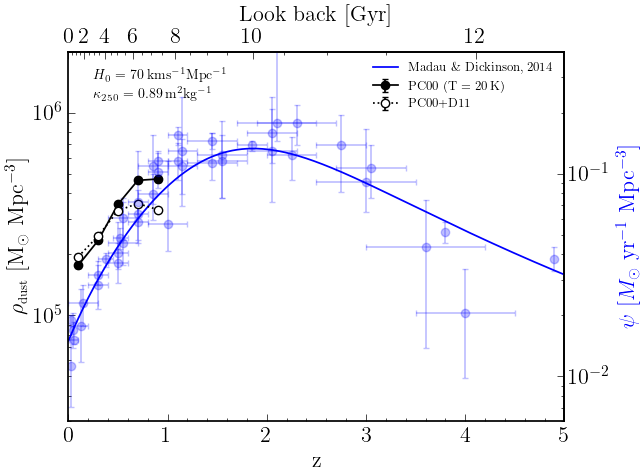

In [37]:
# Madau & Dickinson., 2014 plot formatting
fmt = 'o'
ec = 'b'
mfc = 'b'
alpha = 0.25


fig, ax = plt.subplots()

# Error bars for SGP models
ax.errorbar(SGP_pc00_t20['z_bin_centers'], results_pc00_t20['dmd'], yerr=(results_pc00_t20['dmd_high']-results_pc00_t20['dmd'], results_pc00_t20['dmd']-results_pc00_t20['dmd_low']), fmt='o-', mfc='k', c='k', label=r'PC00 (T = 20\,K)')
ax.errorbar(SGP_pc00_d11['z_bin_centers'], results_pc00_d11['dmd'], yerr=(results_pc00_d11['dmd_high']-results_pc00_d11['dmd'], results_pc00_d11['dmd']-results_pc00_d11['dmd_low']), fmt='o:', mfc='white', c='k', label=r'PC00+D11')

# Madau & Dickinson et al., 2014 error bars
ax.errorbar(madau_sfrd['sanders+2003']['z_bin_centers'], madau_sfrd['sanders+2003']['dmd'], yerr=(madau_sfrd['sanders+2003']['dmd_err_low'],madau_sfrd['sanders+2003']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['takeuchi+2003']['z_bin_centers'], madau_sfrd['takeuchi+2003']['dmd'], yerr=(madau_sfrd['takeuchi+2003']['dmd_err_low'],madau_sfrd['takeuchi+2003']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['wyder+2005']['z_bin_centers'], madau_sfrd['wyder+2005']['dmd'], xerr=np.diff(madau_sfrd['wyder+2005']['z_bins'])/2, yerr=(madau_sfrd['wyder+2005']['dmd_err_low'],madau_sfrd['wyder+2005']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['schiminovich+2005']['z_bin_centers'], madau_sfrd['schiminovich+2005']['dmd'], xerr=np.diff(madau_sfrd['schiminovich+2005']['z_bins'])/2, yerr=(madau_sfrd['schiminovich+2005']['dmd_err_low'],madau_sfrd['schiminovich+2005']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['reddy+2009']['z_bin_centers'], madau_sfrd['reddy+2009']['dmd'], xerr=np.diff(madau_sfrd['reddy+2009']['z_bins'])/2, yerr=(madau_sfrd['reddy+2009']['dmd_err_low'],madau_sfrd['reddy+2009']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['robotham+2011']['z_bin_centers'], madau_sfrd['robotham+2011']['dmd'], yerr=(madau_sfrd['robotham+2011']['dmd_err_low'],madau_sfrd['robotham+2011']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['magnelli+2011']['z_bin_centers'], madau_sfrd['magnelli+2011']['dmd'], xerr=np.diff(madau_sfrd['magnelli+2011']['z_bins'])/2, yerr=(madau_sfrd['magnelli+2011']['dmd_err_low'],madau_sfrd['magnelli+2011']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['cucciati+2012']['z_bin_centers'], madau_sfrd['cucciati+2012']['dmd'], xerr=np.diff(madau_sfrd['cucciati+2012']['z_bins'])/2, yerr=(madau_sfrd['cucciati+2012']['dmd_err_low'],madau_sfrd['cucciati+2012']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['bouwens+2013']['z_bin_centers'], madau_sfrd['bouwens+2013']['dmd'], yerr=(madau_sfrd['bouwens+2013']['dmd_err_low'],madau_sfrd['bouwens+2013']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['schenker+2013']['z_bin_centers'], madau_sfrd['schenker+2013']['dmd'], yerr=(madau_sfrd['schenker+2013']['dmd_err_low'],madau_sfrd['schenker+2013']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['magnelli+2013']['z_bin_centers'], madau_sfrd['magnelli+2013']['dmd'], xerr=np.diff(madau_sfrd['magnelli+2013']['z_bins'])/2, yerr=(madau_sfrd['magnelli+2013']['dmd_err_low'],madau_sfrd['magnelli+2013']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)
ax.errorbar(madau_sfrd['gruppioni+2013']['z_bin_centers'], madau_sfrd['gruppioni+2013']['dmd'], xerr=np.diff(madau_sfrd['gruppioni+2013']['z_bins'])/2, yerr=(madau_sfrd['gruppioni+2013']['dmd_err_low'],madau_sfrd['gruppioni+2013']['dmd_err_high']), fmt=fmt, c=ec, mfc=mfc, alpha=alpha)

# Plot of Madau & Dickinson trend
ax.plot(z_range, sfrd_to_dmd(double_powerlaw(z_range, 0.015, 2.7, 2.9, 5.6)), c=ec, label=r'Madau \& Dickinson, 2014')

# Cosmology text
ax.text(0.05, 0.925, r'$H_0$ = 70\,kms$^{-1}$Mpc$^{-1}$', fontsize=10, transform=ax.transAxes)
ax.text(0.05, 0.875, r'$\kappa_{250}$ = 0.89\,m$^{2}$kg$^{-1}$', fontsize=10, transform=ax.transAxes)

# Second axes for lookback time and star formation rate density
ax.semilogy()
ax.tick_params(axis='x', which='both', top=False)
ax.tick_params(axis='y', which='both', right=False)
secax_x = ax.secondary_xaxis('top', functions=(z_to_lookback, lookback_to_z))
secax_y = ax.secondary_yaxis('right', functions=(dmd_to_sfrd, sfrd_to_dmd))
secax.set_xticks(np.array([0,2,4,6,8,10,12]))

ax.set_xlim(0,5)
ax.set_ylim(3e4, 2e6)

ax.set_xlabel(r'z')
ax.set_ylabel(r'$\rho_{\textrm{\small dust}}$ [M$_\odot$ Mpc$^{-3}$]')
secax_x.set_xlabel(r'Look back [Gyr]')
secax_y.set_ylabel(r'$\psi$ [$M_{\odot}$ yr$^{-1}$ Mpc$^{-3}$]', color='b')
ax.legend(fontsize=9, loc='upper right')
plt.savefig(os.getcwd() + '/figures/Figure_3_9.pdf', dpi=1000, bbox_inches='tight')
plt.show()